# Regression Model

In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
    confusion_matrix
)

class LogisticRegressionCreditRiskModel:

    def __init__(self):
        self.data = None
        self.data_x = None
        self.data_y = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.prob_pred = None
        self.y_pred = None

    def load_data(self, path):
        """Loads the loan data from a CSV file."""
        self.data = pd.read_csv(path)

    def preprocess_features(self, x_variables):
        """Preprocesses the features (X variables)."""
        data_x_num = self.data[x_variables].select_dtypes(exclude='object')
        data_x_obj = self.data[x_variables].select_dtypes(include='object')
        
        if not data_x_obj.empty:
            # One-hot encoding
            data_x_obj = pd.get_dummies(data_x_obj)
        
        dfs_x = [df_x for df_x in [data_x_num, data_x_obj] if not df_x.empty]
        self.data_x = pd.concat(dfs_x, axis=1)

    def preprocess_target(self, y_variables):
        """Preprocesses the target (Y variables)."""
        data_y_num = self.data[y_variables].select_dtypes(exclude='object')
        data_y_obj = self.data[y_variables].select_dtypes(include='object')
        
        if not data_y_obj.empty:
            # One-hot encoding
            data_y_obj = pd.get_dummies(data_y_obj)
        
        dfs_y = [df_y for df_y in [data_y_num, data_y_obj] if not df_y.empty]
        self.data_y = pd.concat(dfs_y, axis=1)

    def train_test_split(self, test_size=0.4, random_state=126):
        """Splits the loan dataset into train and test datasets."""
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.data_x, self.data_y,
            test_size=test_size,
            random_state=random_state
        )

    def train_model(self, solver='lbfgs'):
        """Trains the LogisticRegression model."""
        self.model = LogisticRegression(solver=solver)
        self.model.fit(self.x_train, np.ravel(self.y_train))

    def predict_proba(self):
        """Returns the probability of default for the test data."""
        self.prob_pred = pd.DataFrame(
            self.model.predict_proba(self.x_test), columns=["prob_default", "prob_not_default"])
        return self.prob_pred

    def predict_status(self, threshold=0.5):
        """Returns the predicted loan status for the test data."""
        self.y_pred = self.predict_proba()["prob_default"]
        self.y_pred = self.y_pred.apply(lambda prob : 1 if prob > threshold else 0)
        return self.y_pred

    def score(self):
        """Returns the accuracy of the model on the test data."""
        return self.model.score(self.x_test, self.y_test)

    def print_classification_report(self):
        """Prints the classification report for credit Non-Default and Default."""
        target_names = ['Non-Default', 'Default']
        print(classification_report(self.y_test, self.y_pred, target_names=target_names))

    def precision_recall_fscore_support(self):
        """
        Returns precision, recall, F1-score, and support for each class.
        precision: percentage of positive predictions that are true positives
        recall or sensitivity: percentage of actual instances that were predicted correctly
                               true positives / (true positives + false negatives)
        
        """
        class_report = precision_recall_fscore_support(self.y_test, self.y_pred)
        cols = ['Non-Default', 'Default']
        indx = ['Precision', 'Recall', 'F1-Score', 'Support']
        self.classification_report = pd.DataFrame(class_report, columns=cols, index=indx)
        return self.classification_report

    def plot_roc_curve(self):
        """Plots the ROC curve for the model."""
        prob_default = self.predict_proba()['prob_default']
        fpr, tpr, thresholds = roc_curve(np.ravel(self.y_test), np.ravel(prob_default))
        plt.plot(fpr, tpr, color='darkorange')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
        
        
    def confusion_matrix(self):
        print(confusion_matrix(self.y_test, self.predict_status()))


In [390]:
crm = LogisticRegressionCreditRiskModel()
crm.load_data('cr_loan_nout_nmiss.csv')
crm.preprocess_features(['person_income','person_age','loan_int_rate'])
crm.preprocess_target(['loan_status'])
crm.train_test_split(test_size=0.4, random_state=129)
crm.train_model()
pred_y = crm.predict_status()
cr = crm.print_classification_report()
crm.precision_recall_fscore_support()

              precision    recall  f1-score   support

 Non-Default       0.40      0.04      0.08      9205
     Default       0.18      0.77      0.30      2579

    accuracy                           0.20     11784
   macro avg       0.29      0.41      0.19     11784
weighted avg       0.35      0.20      0.12     11784



,Non-Default,Default
Precision,0.399177,0.184517
Recall,0.042151,0.773556
F1-Score,0.076250,0.297961
Support,9205.000000,2579.000000


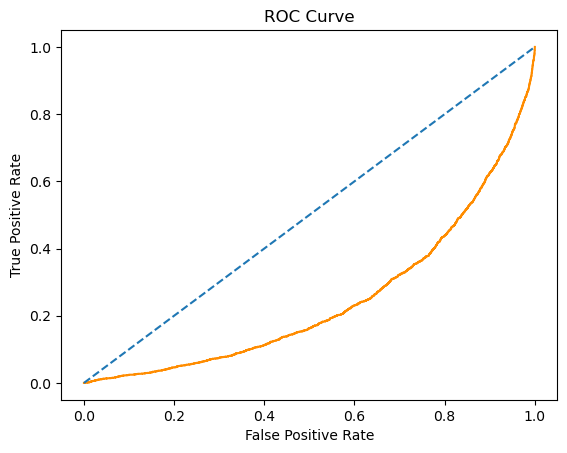

In [391]:
crm.plot_roc_curve()

In [392]:
roc_auc_score(y_test, prob_default)

0.49150663154016305

In [393]:
crm.confusion_matrix()

[[ 388 8817]
 [ 584 1995]]
